In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [53]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns

In [54]:
from zipfile import ZipFile
file_name="dataset-resized.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")


done


# New section

In [55]:

os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'plastic', 'paper', 'trash', 'cardboard', 'metal', 'glass']

In [56]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [ ]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

In [58]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/content/data')

In [59]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=16)

In [60]:
data

ImageDataBunch;

Train: LabelList (1262 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Valid: LabelList (630 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
plastic,plastic,plastic,plastic,plastic
Path: /content/data;

Test: LabelList (635 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/data

In [61]:
print(data.classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


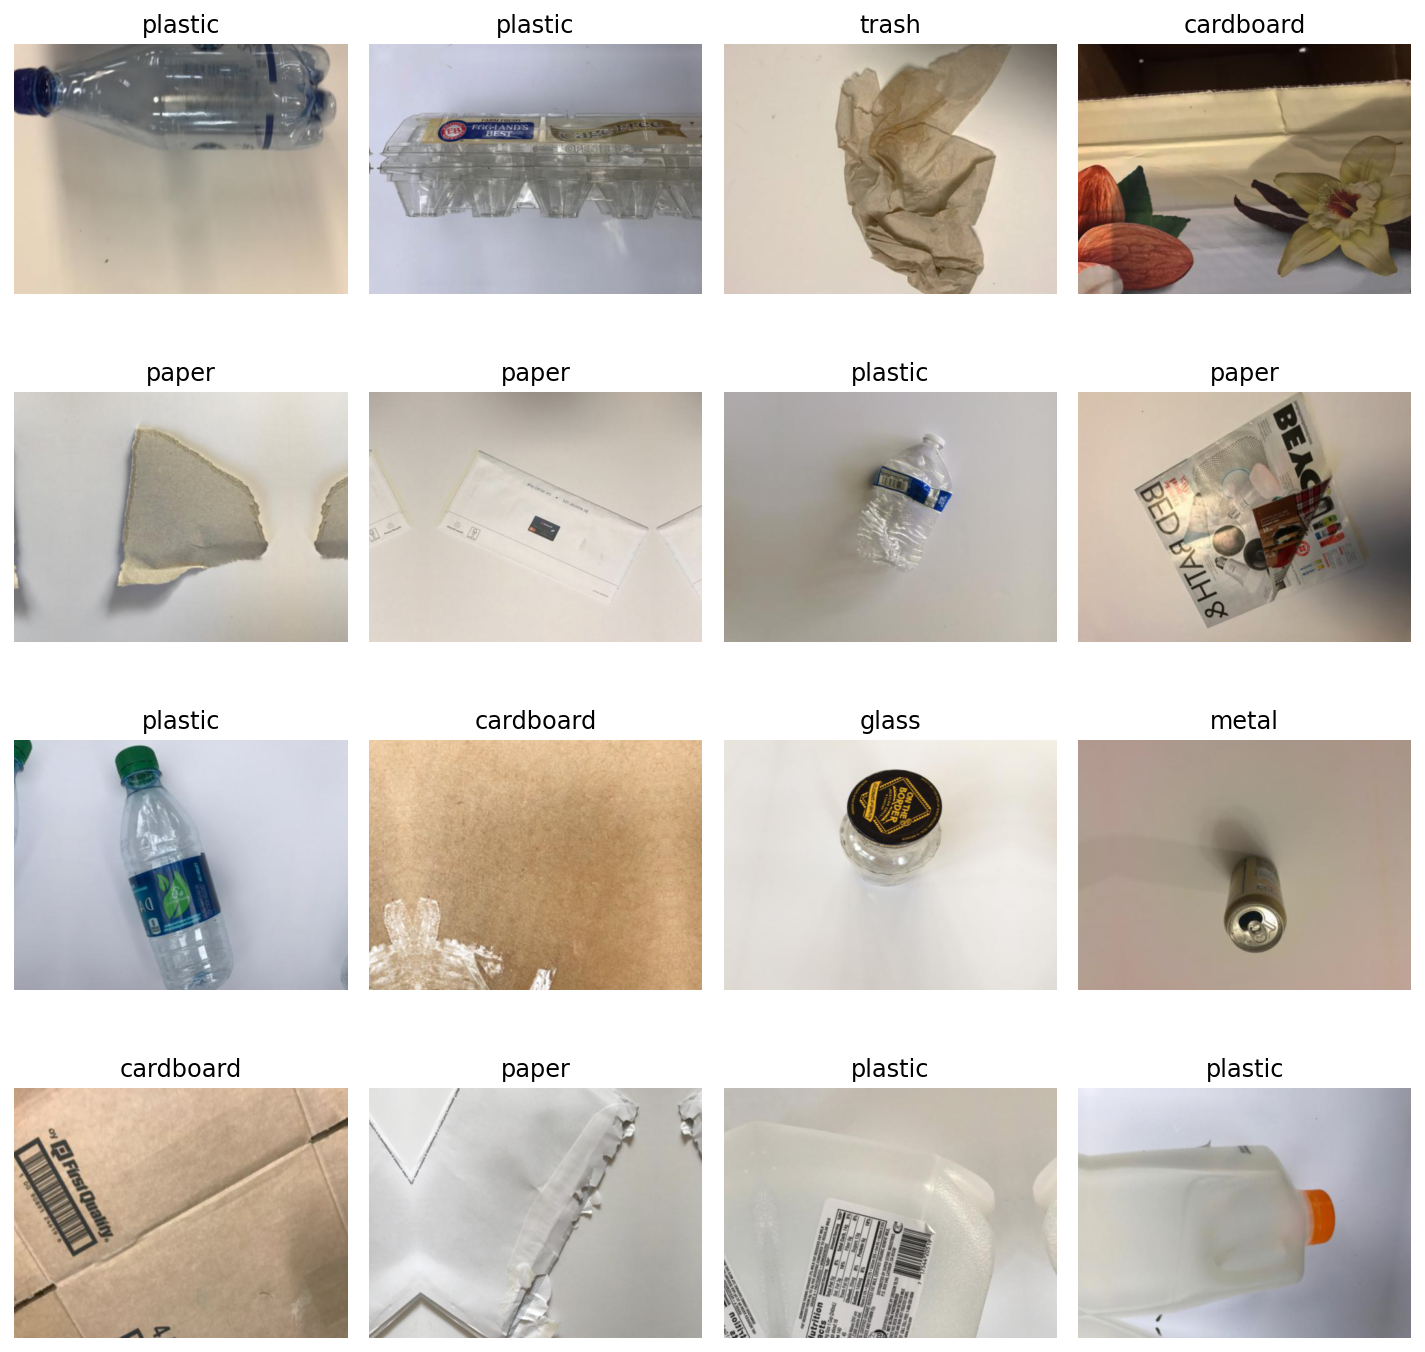

In [62]:
data.show_batch(rows=10,figsize=(10,10))



In [63]:

learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [64]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-03
Min loss divided by 10: 3.02E-03


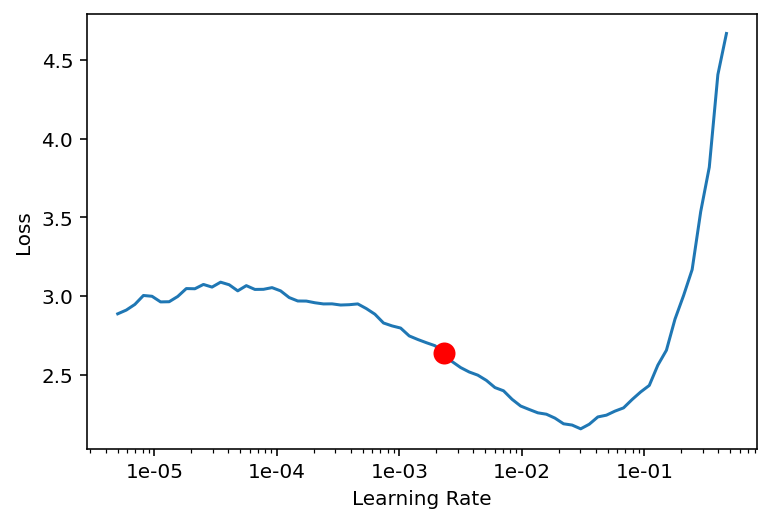

In [66]:

learn.freeze()
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)


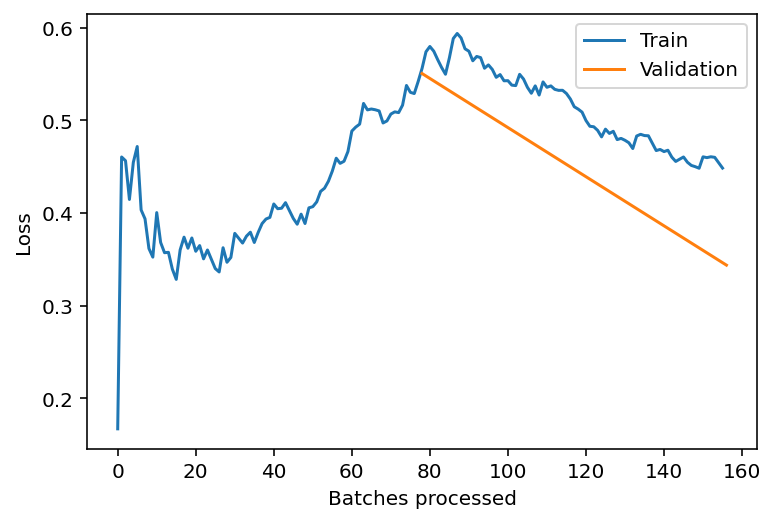

In [87]:
learn.fit_one_cycle(2, max_lr=3e-3, pct_start=0.1, div_factor=10, final_div=30, wd=5e-3, moms=(0.9, 0.8))
learn.save('stage-1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-05
Min loss divided by 10: 1.10E-05


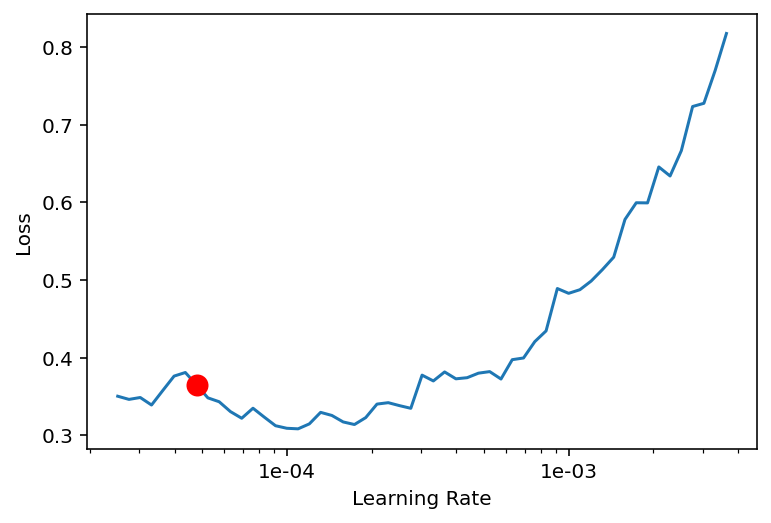

In [88]:
# unfreeze and search appropriate learning rate for full training
learn.unfreeze()
learn.lr_find(start_lr=slice(1e-6, 1e-5), end_lr=slice(1e-2, 1e-1), wd=1e-3)
learn.recorder.plot(suggestion=True)


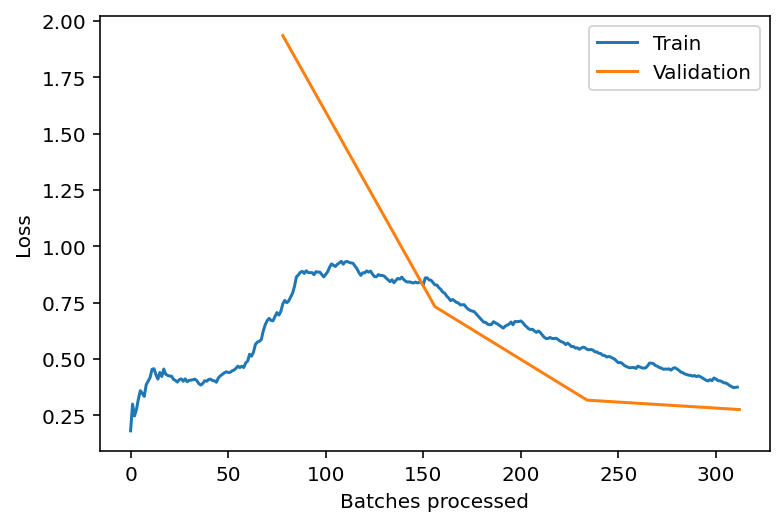

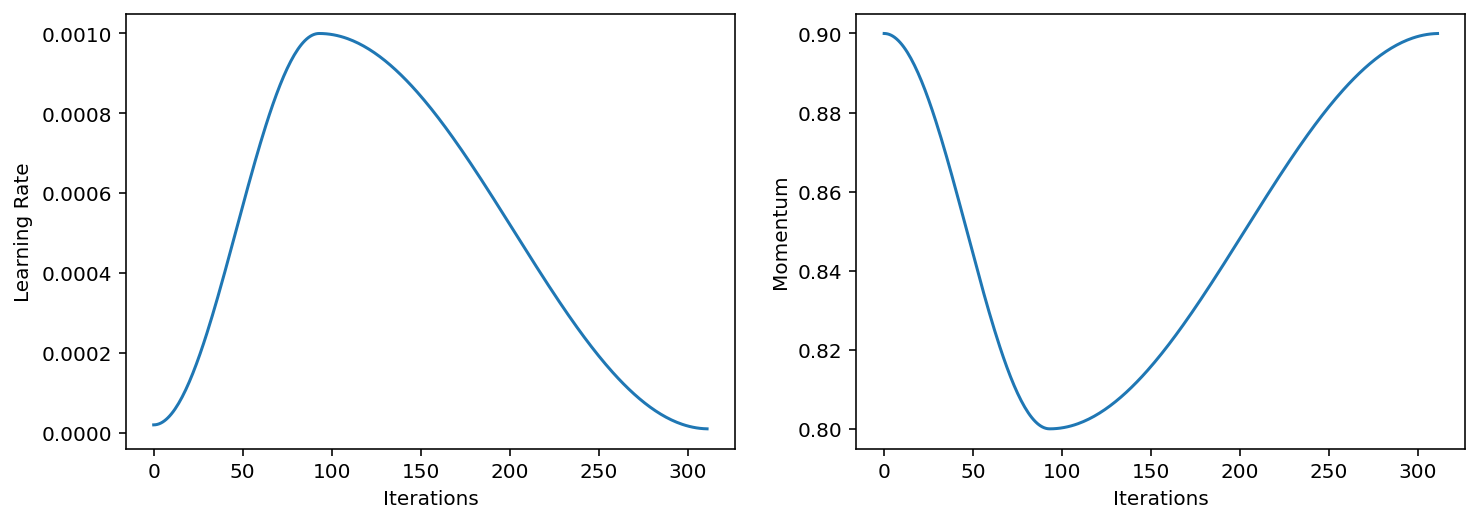

In [89]:
# train all layers
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), div_factor=50, final_div=100, wd=1e-3, moms=(0.9, 0.8))
learn.save('stage-2')
learn.recorder.plot_losses()
# schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

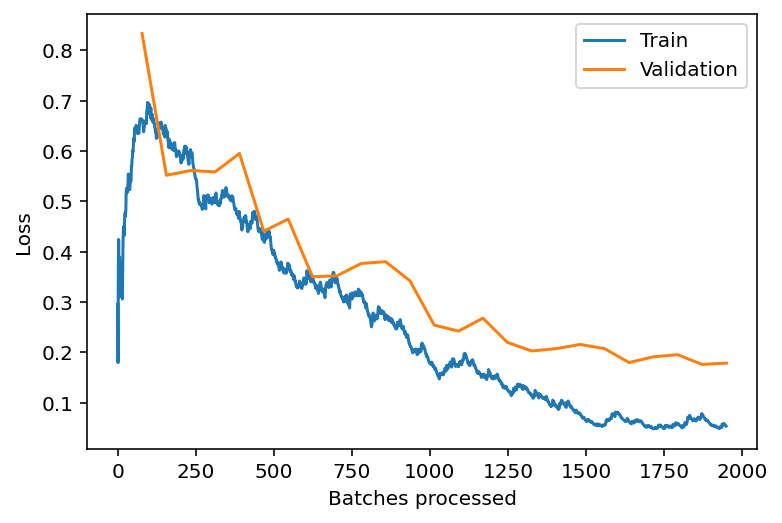

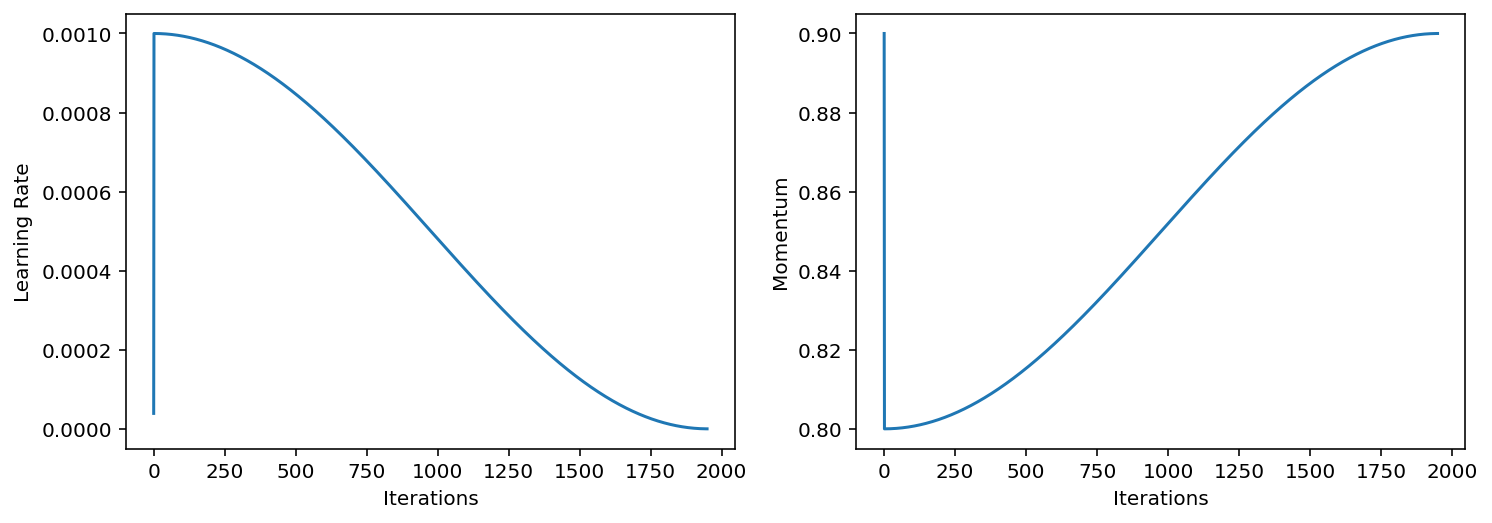

In [90]:
# train all layers
learn.fit_one_cycle(cyc_len=25, max_lr=slice(1e-4, 1e-3), pct_start=0, final_div=1000, wd=1e-3, moms=(0.9, 0.8)) # warm restart: pct_start=0
learn.save('stage-3')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)

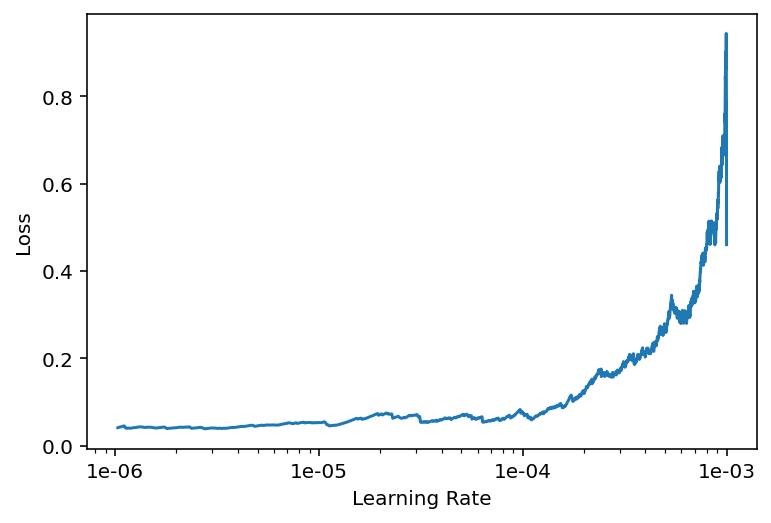

In [ ]:
learn.recorder.plot()


In [67]:
learn.fit_one_cycle(10,max_lr=2.29E-03)

In [68]:

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()


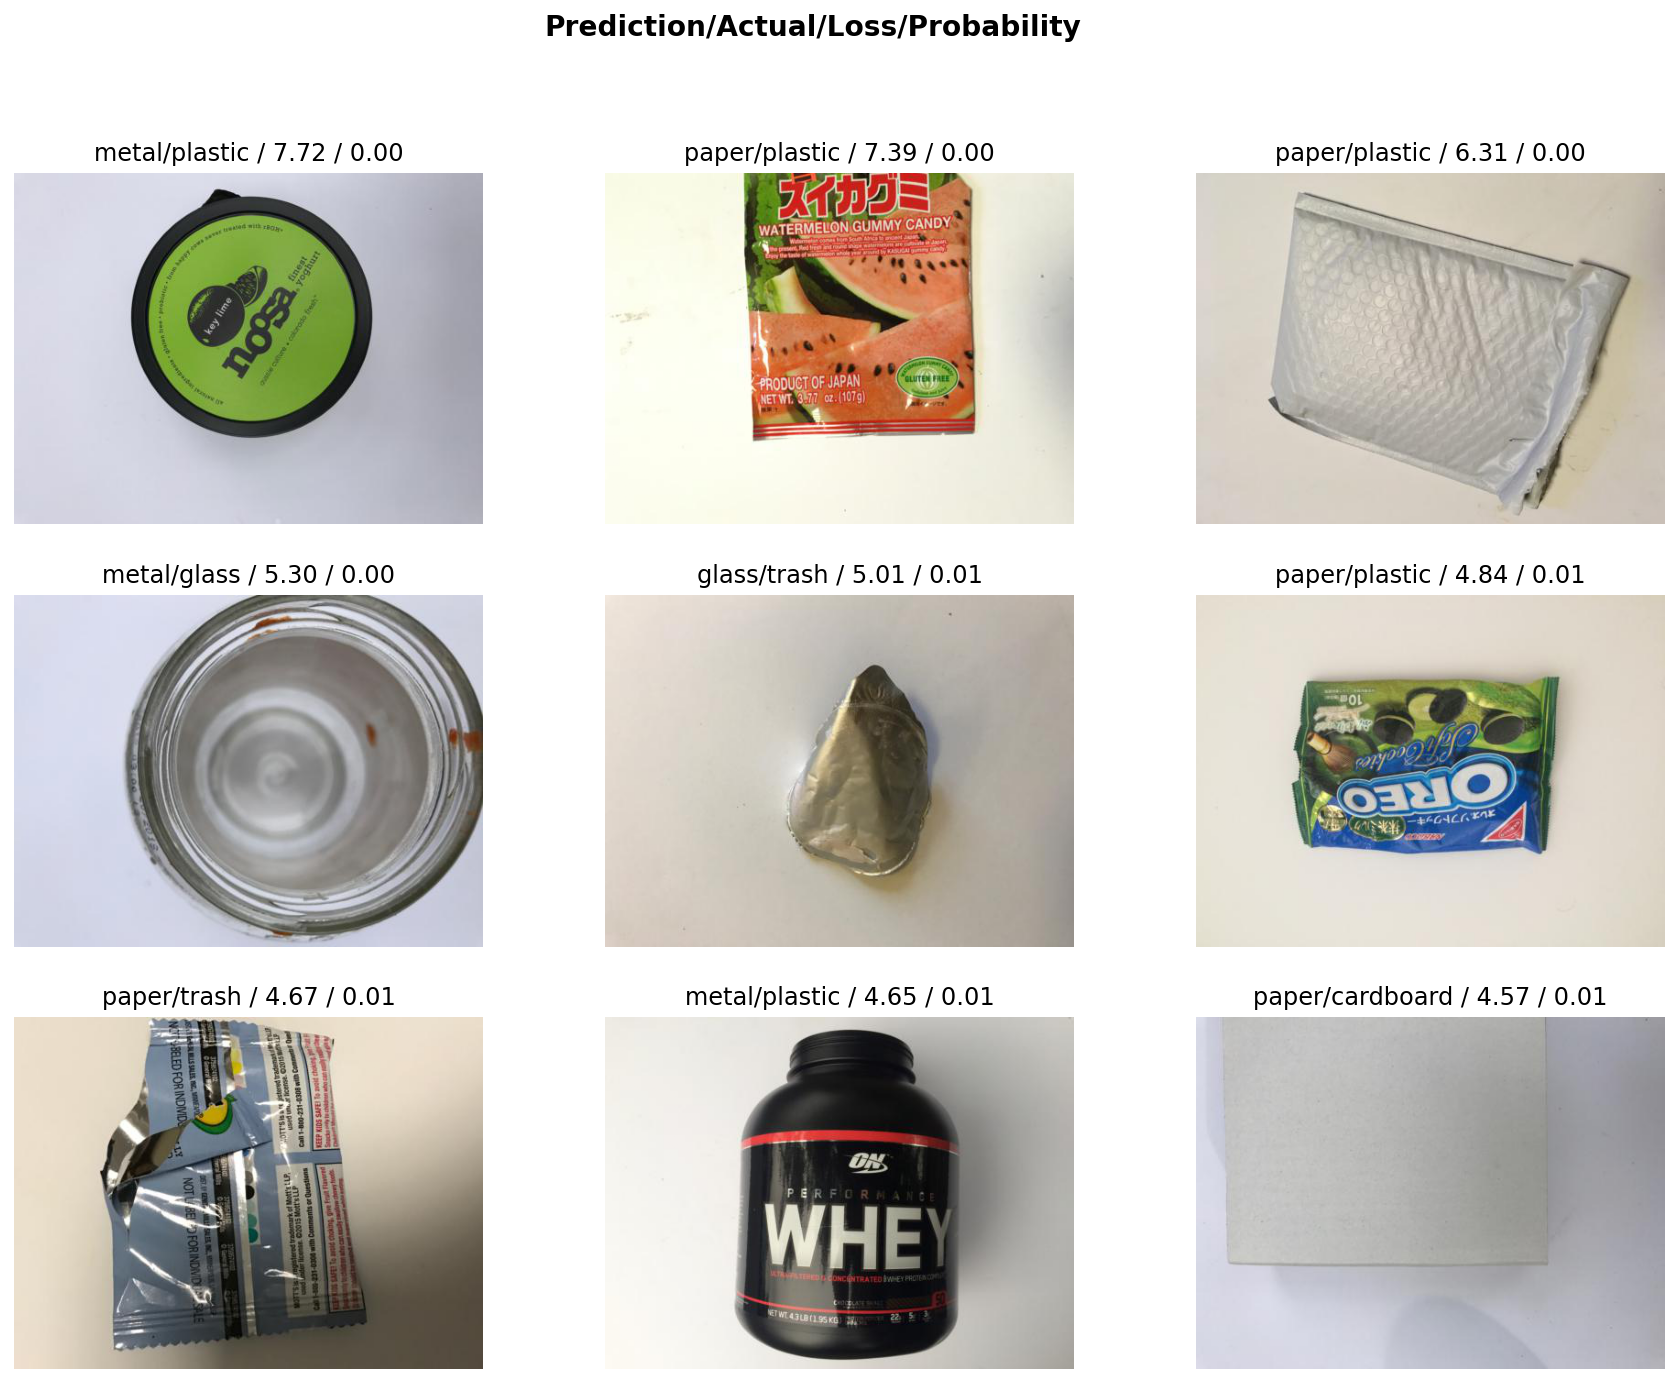

In [69]:
interp.plot_top_losses(9, figsize=(15,11))

In [70]:

from sklearn import metrics
from sklearn.metrics import confusion_matrix

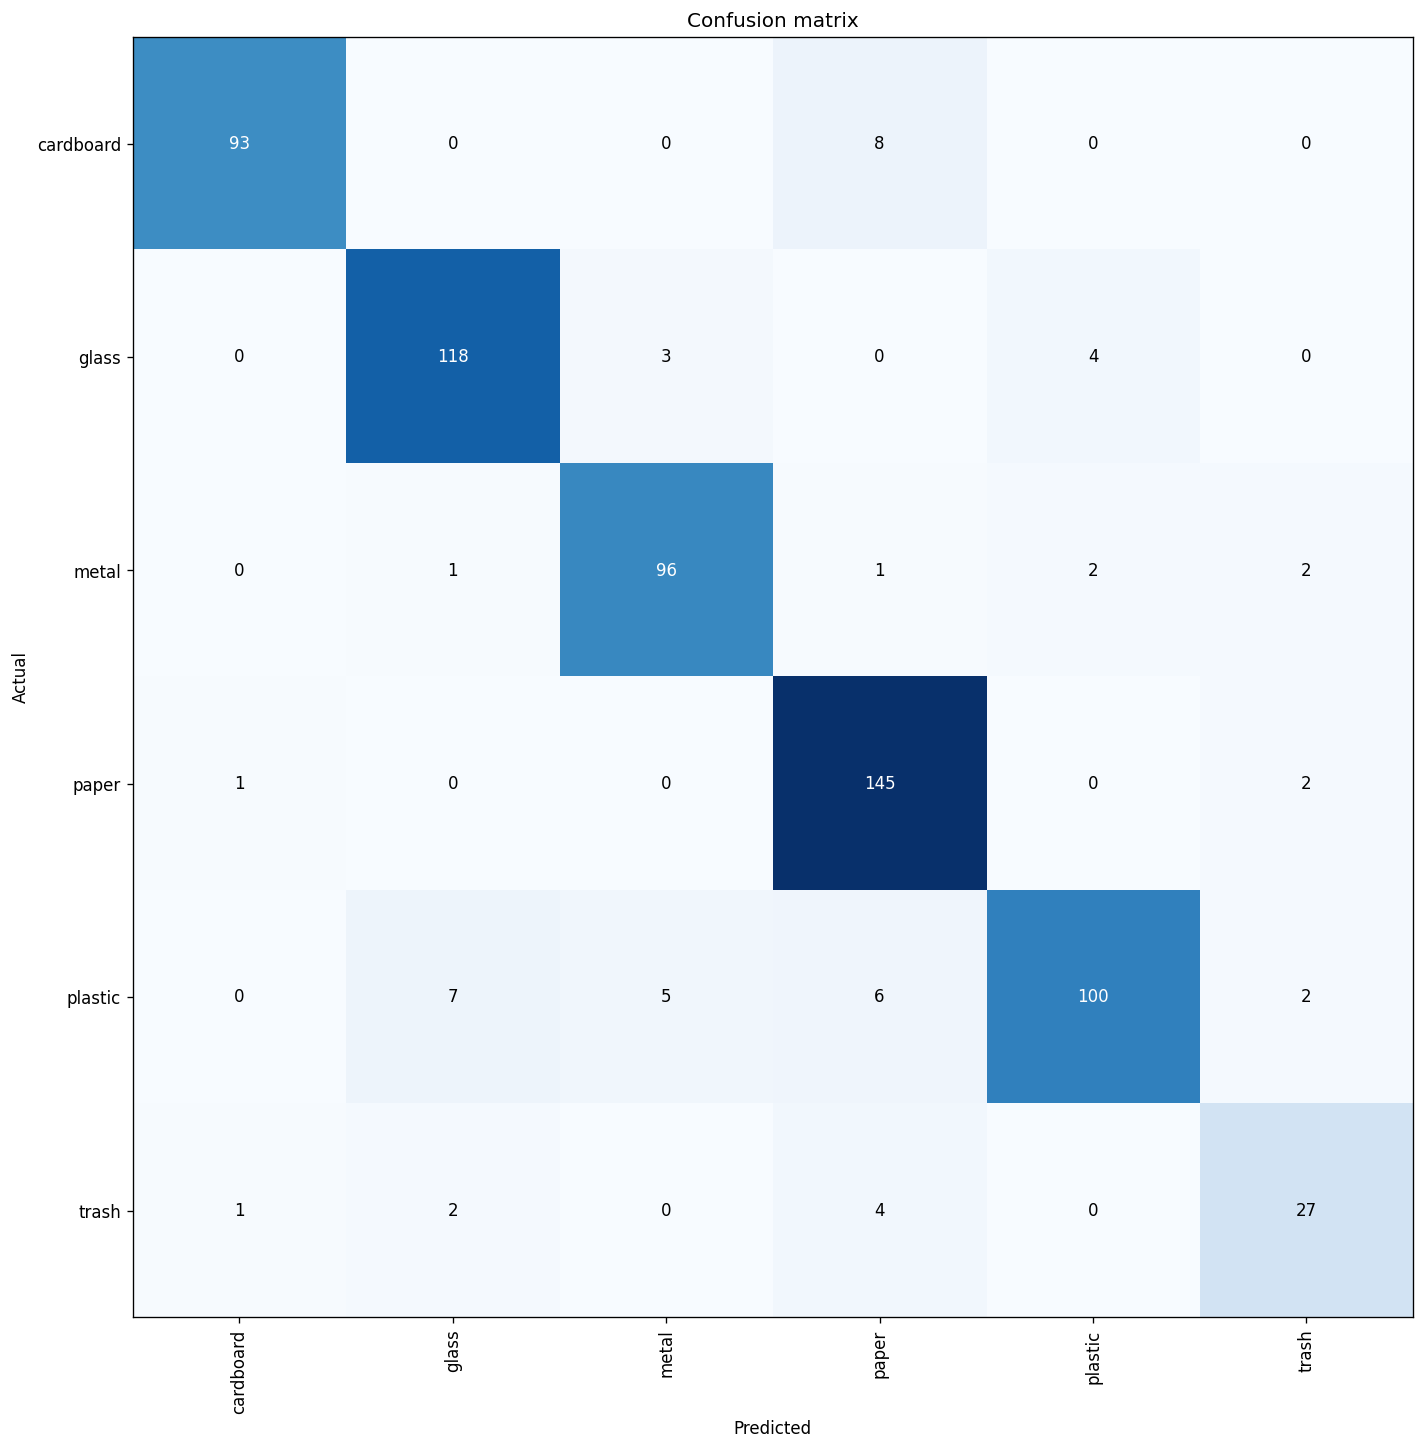

In [71]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [72]:

interp.most_confused(min_val=2)

[('cardboard', 'paper', 8),
 ('plastic', 'glass', 7),
 ('plastic', 'paper', 6),
 ('plastic', 'metal', 5),
 ('glass', 'plastic', 4),
 ('trash', 'paper', 4),
 ('glass', 'metal', 3),
 ('metal', 'plastic', 2),
 ('metal', 'trash', 2),
 ('paper', 'trash', 2),
 ('plastic', 'trash', 2),
 ('trash', 'glass', 2)]

In [73]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [74]:
print(preds[0].shape)
preds[0]

torch.Size([635, 6])


tensor([[7.4347e-03, 4.0719e-02, 9.4808e-01, 2.7471e-03, 2.8936e-04, 7.2560e-04],
        [1.0555e-03, 1.3216e-01, 7.8278e-02, 9.5935e-05, 7.8803e-01, 3.7813e-04],
        [1.8167e-04, 6.3455e-02, 5.8674e-04, 5.0085e-06, 9.3543e-01, 3.4049e-04],
        ...,
        [5.4346e-01, 1.0564e-02, 2.1437e-03, 4.3707e-01, 6.1309e-03, 6.3481e-04],
        [3.5392e-07, 1.1130e-06, 9.9985e-01, 1.7509e-06, 1.3307e-04, 1.6053e-05],
        [2.2271e-01, 5.0771e-02, 3.4597e-01, 2.1227e-02, 1.3253e-03, 3.5799e-01]])

In [75]:
data.classes

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [76]:

## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [77]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

In [78]:

yhat

['metal',
 'plastic',
 'plastic',
 'metal',
 'paper',
 'trash',
 'metal',
 'glass',
 'paper',
 'plastic',
 'trash',
 'glass',
 'glass',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'paper',
 'plastic',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'trash',
 'cardboard',
 'plastic',
 'plastic',
 'cardboard',
 'cardboard',
 'cardboard',
 'metal',
 'metal',
 'plastic',
 'glass',
 'cardboard',
 'cardboard',
 'glass',
 'cardboard',
 'paper',
 'paper',
 'plastic',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'metal',
 'paper',
 'cardboard',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'plastic',
 'plastic',
 'metal',
 'cardboard',
 'metal',
 'cardboard',
 'plastic',
 'glass',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'paper',
 'glass',
 'paper',
 'paper',
 'metal',
 'metal',
 'glass',
 'glass',
 'plastic',
 'glass',
 'plastic',
 'metal',
 'paper',
 'metal',
 'glass',
 'plastic',
 'paper',
 'metal',
 'cardboard',
 'cardboard',
 'metal',
 'glass',
 'paper',


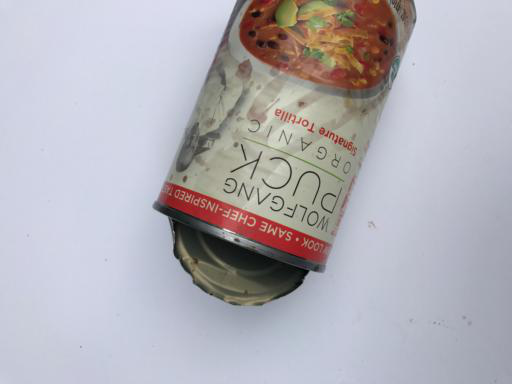

In [79]:
learn.data.test_ds[0][0]

In [80]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [81]:

## predicted values
print(yhat[0:5])
## actual values
print(y[0:5])

['metal', 'plastic', 'plastic', 'metal', 'paper']
['metal', 'glass', 'plastic', 'metal', 'metal']


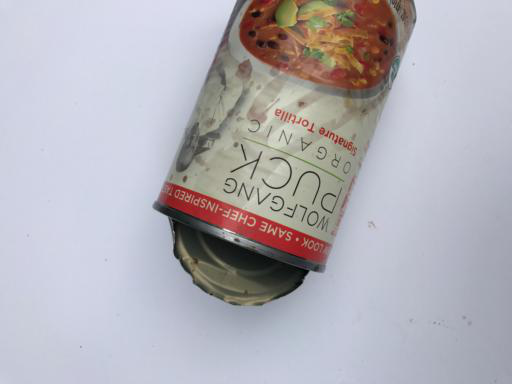

In [82]:
learn.data.test_ds[0][0]

In [83]:
cm = confusion_matrix(y,yhat)
print(cm)

[[ 96   0   0   4   0   1]
 [  0 115   6   0   5   0]
 [  2  13  85   3   0   0]
 [  0   0   1 146   0   2]
 [  0   8   2   1 107   3]
 [  1   1   1   6   2  24]]


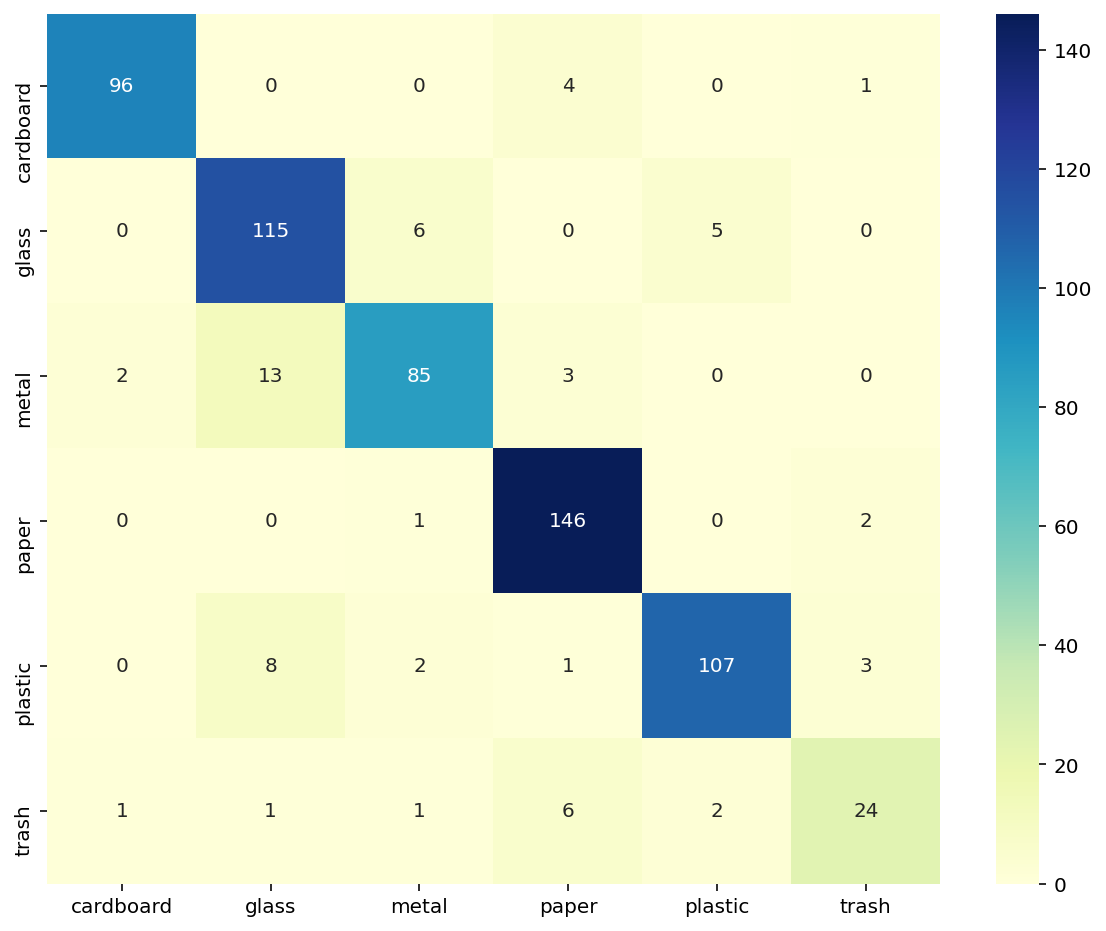

In [84]:
df_cm = pd.DataFrame(cm,waste_types,waste_types)

plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

In [85]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [86]:
accuracy = correct/sum(sum(cm))
accuracy

0.9023622047244094

In [91]:
## delete everything when you're done to save space
shutil.rmtree("data")
shutil.rmtree('dataset-resized')